# Previous Tissue Analysis

This notebook demonstrates our approach to analyzing tissue within raw ultrasound data to identify an optimal reference area (RA) for a region of interest (ROI).

B-Mode images of a random patient are used for visualization.


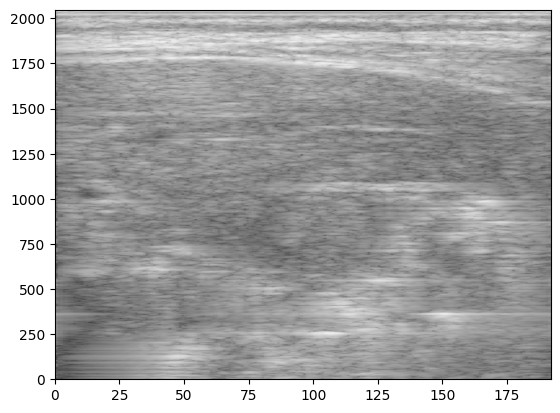

In [ ]:
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import numpy as np 
import os 
filepath = "insert/your/file/path/here" # TODO add your path here 


f_raw = r"\RAW_DATA\UKDCEUS040\Rohdaten\raw_0_0.tar_extracted\C3_large_rf.raw.rf.no_tgc.npy" # TODO or use L15
f_raw = os.path.join(filepath,f_raw)
frame = 0
x = 0

# Generate a sample input signal
signals = np.load(f_raw)
raw_2d = signals[:,:,frame]
#plt.plot(signals[0,:,frame])


# Compute the analytic signal using the Hilbert transform to get the envelope
analytic_signal = hilbert(np.abs(raw_2d), axis=0)
amplitude_envelope = np.abs(analytic_signal)

# Apply logarithmic transformation for better visualization
amplitude_envelope = 20 * np.log10(1 + amplitude_envelope)

# Rotate the envelope 90 degrees counterclockwise and flip it vertically
amplitude_envelope = np.rot90(amplitude_envelope)
amplitude_envelope = np.flipud(amplitude_envelope)

# Apply rotation and mirroring to rw data 
raw_2d = np.rot90(raw_2d)
raw_2d = np.flipud(raw_2d)
#plot 
plt.imshow(amplitude_envelope, cmap='gray', aspect='auto', extent=[0, amplitude_envelope.shape[1], 0, amplitude_envelope.shape[0]])


# 1.) Theoretical Background
***Ultrasound***: Send high frequency sound wave (pulse) with a transducer (containing piezoelectric crystals) into the tissue, measure the reflected signal with the same transducer.

***Qualitative Ultrasound(QUS)***: Focuses on quantifying the properties of tissues instead of visual imaging purposes.

***Signal Properties***
The received signal can be interpreted as the following equation

\begin{equation}
S_R(\omega,t) = \left[S_T(\omega,t) \cdot e^{-\alpha \omega t}  \right] * T(\omega,t)
\end{equation}
with:
* $\omega$: Signal frequency 
* $t$: time 
* $\alpha$: attenuation coefficient 
* $S_{T(\omega,t)}$: Initial signal sent from the transducer
* $S_{R(\omega,t)}$: Signal/Reflection received 
* $T_{(\omega,t)}$: Reflections/Scatterings due to tissue properties 
* $*$: convolution operator 


The equation states that the received signal is a convolution of the initial signal with the tissue properties. The properties of the tissue is what we are looking for. Especially for lesions which are our regions of interest(ROI)

## Further effects
***Attenuation***: The signal gets weaker exponentially  with the depth, due to scattering and reflections $e^{-\alpha \omega t}$.
 
$\rightarrow$ comparing tissues( eg: lesion vs healthy) of different depth leads to different signal strengths.

***Shadowing***: Tissues that produce stronger reflections can also impede the signal's propagation, potentially obscuring the visualization of deeper tissues. 


# Data 
49 patients with either L15 or C3 raw ultrasound data. Some containing dicom images. 

# Aim
QUS can be used to improve disease detection and learn more about the disease property. However, we are challenged by the nature of ultra sound signal processing.

Annotated lesions/ROIs can not be analysed independently from the surrounding (especially previous) tissue. Raw Ultrasound data can be used to find neighbouring healthy tissue with same properties in the previous regions compared to the previous region of the ROI. 

This new area can be seen as a reference image, which can be used to normalize the extracted ROI w.r.t. to its depth and previous tissue. 


# Objective
Generally, previous tissue affects what we see in the ROI. This should be considered when looking for reference area.
Requirements:
1. Should be at the same depth
    - Use same depth and same size for reference ROI (trivial)
2. Should have similar previous tissue as the previous area of the ROI 
    - Compare previous tissues for similarity with convolution techniques (guide the user with this knowledge).
3. Should contain homogenous healthy tissue 
    - Leave this task to the physician.


# 2.) Convolutions
Idea: extract the tissue area w.r.t. the ultrasound device before the ROI.

In [36]:
# First some helper functions 
def roi_with_anchor(coords):
    """ Transform defined square from lines to anchor point(bottom left) with height and width"""
    v1,v2,h1,h2 = coords
    x = h1
    y = v1
    h = v2-v1
    w = h2-h1
    return x,y,w,h

def path2roi(img,roi):
    """get previous tissue coordinates"""
    v1,v2,h1,h2 = roi
    y_max,_ = np.shape(img)
    return v2,y_max,h1,h2
    
def plt_rect(ax,coords,color="red"):
    """draw a rectangle at the coords"""
    x,y,width,height =  roi_with_anchor(coords)
    return plt.Rectangle((x, y), width, height, edgecolor=color, facecolor='none', linewidth=2)



## Plot ROI and the tissue area on top of the ROI 
A random region is chosen as a ROI (red rectangle) to illustrate where the previous tissue(green rectangle) is located

Coords ROI:  [1000, 1500, 40, 50]
Coords on top of ROI:  (1500, 2048, 40, 50)
Coords : v1,v2,h1,h2


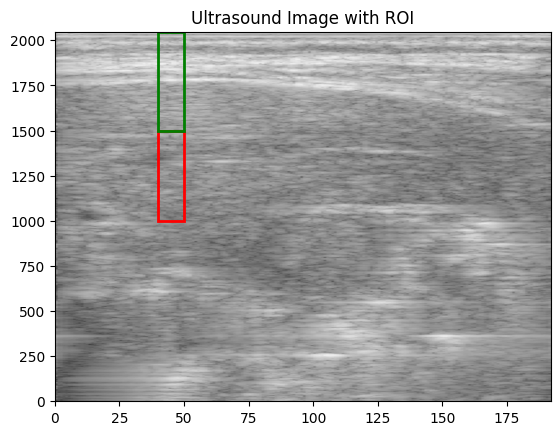

In [37]:
roi = [1000,1500,40,50] # v1,v2,h1,h2
img = amplitude_envelope
ontop_roi = path2roi(img,roi)
print("Coords ROI: ", roi)
print("Coords on top of ROI: ",ontop_roi)
print("Coords : v1,v2,h1,h2")
 
# Create a plot
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray', aspect='auto', extent=[0, img.shape[1], 0, img.shape[0]])

# Create a rectangle patch to highlight the ROI
rect_roi = plt_rect(ax,roi,color="red")
rect_path = plt_rect(ax,ontop_roi,color="green")
# Add the rectangle to the plot
ax.add_patch(rect_roi)
ax.add_patch(rect_path)
plt.title("Ultrasound Image with ROI")
plt.show()

## Extract ontop of ROI as convolution kernel 
We will now use the previous tissue as a kernel so that we can apply operations like convolutions or cross correlations on the other previous tissue regions. 

To illustrate the kernel, the B-Mode is shown below. 

<function matplotlib.pyplot.show(close=None, block=None)>

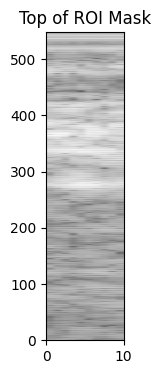

In [38]:
def extract_kernel(img,ontop_roi):
    """ extract the mask, notice that image is rotated!"""
    v1,v2,h1,h2 = ontop_roi
    y_max,_ = np.shape(img)
    return img[y_max-v2:y_max-v1,h1:h2] 


img_roi = extract_kernel(img,ontop_roi)
fig, ax = plt.subplots(figsize=(1,4))
ax.imshow(img_roi, cmap='gray', aspect='auto', extent=[0, img_roi.shape[1], 0, img_roi.shape[0]])
plt.title("Top of ROI Mask")
plt.show

## Next Steps 
1. Apply mathematical operations to compare similarity of previous tissue types

In [39]:
# Further helper functions

def minmax(list_pre,a,b):
    """Normalize list_pre from [min,max] to [a,b]"""
    A,B = np.min(list_pre),np.max(list_pre) 
    return np.array([(x-A)/(B-A)*(b-a)+a for x in list_pre])


def apply_kernel(img,ontop_roi,kernel_type="conv",getall=False):
    """Slide the kernel over the tissue next to it
       returns y (list) : the output of the operation
               x (list) : location of y
                """
    k_types = ["conv","row_wise_conv","cross_correlation"]
    if getall:
        #recursive call for all k_types
        x_all,y_all = [],[]
        for k_type in k_types:
            x,y,_ = apply_kernel(img,ontop_roi,kernel_type=k_type,getall=False)
            x_all.append(x)
            y_all.append(y)
        return x_all,y_all,k_types

    v1,v2,h1,h2 = ontop_roi
    width = h2-h1
    img = minmax(img.copy(),-1,1)
    y_max,x_max = np.shape(img)

    if kernel_type == "conv":
        flipped_kernel =  np.flip(extract_kernel(img,ontop_roi), axis=(0, 1)).copy()
    elif kernel_type == "row_wise_conv":
        flipped_kernel =  np.flip(extract_kernel(img,ontop_roi), axis=(1)).copy()
    elif kernel_type == "cross_correlation":
       flipped_kernel = extract_kernel(img,ontop_roi).copy()
    else:
        raise ValueError(f'kernel_type not known,only {k_types}')
        
    hist_list = []
    for i in range(x_max -width +1):
        area = img[y_max-v2:y_max-v1,i:i+width].copy()
        #area /= np.sum(area)
        hist_list.append(np.sum(area*flipped_kernel))

    normalized =minmax(hist_list,0,1)
    x = [i+width//2 for i in range(len(hist_list))]
    y = np.asarray(normalized)
    return x,y,kernel_type

In [40]:
# more helper function, just continue to scroll down ... 
def plotter(x,y,img,roi,ontop_roi,title=None,plot_all=False): 

    # Create a colormap
    cmap = plt.get_cmap('viridis')

    
    if not plot_all:
        # Normalize the data to range [0, 1]
        normalize = plt.Normalize(vmin=min(y), vmax=max(y)) 
        # Create a figure with subplots
        fig, (ax1, ax2) = plt.subplots(2, 1,gridspec_kw={'height_ratios': [1, 3]}, figsize=(8, 8),sharex=True)
        ax1.set_title(title)
        # Plot the bar plot on top subplot
        bars = ax1.bar(x, y, color=cmap(normalize(y)))
        #ax1.set_yscale("log")

        # plot image 
        ax2.imshow(img, cmap='gray', aspect='auto', extent=[0, img.shape[1], 0, img.shape[0]])
        # Create a rectangle patch to highlight the ROI
        rect_roi = plt_rect(ax2,roi,color="red")
        rect_path = plt_rect(ax2,ontop_roi,color="green")
        # Add the rectangle to the plot
        ax2.add_patch(rect_roi)
        ax2.add_patch(rect_path)

    else: 
        n = len(x)
        # Create a figure with subplots
        fig, axs = plt.subplots(n+1, 1,gridspec_kw={'height_ratios': [1]*n+[3]}, figsize=(8, 8+2),sharex=True)

        for idx,(a,b,title_sub) in enumerate(zip(x,y,title)):
            # Normalize the data to range [0, 1]
            normalize = plt.Normalize(vmin=min(b), vmax=max(b))     
            # Plot the bar plot on top subplot
            bars = axs[idx].bar(a, b, color=cmap(normalize(b)))
            axs[idx].set_title(title_sub)
            axs[idx].set_ylim((0,1))
            #axs[idx].set_yscale("log")
        # plot image 
        axs[-1].imshow(img, cmap='gray', aspect='auto', extent=[0, img.shape[1], 0, img.shape[0]])
        # Create a rectangle patch to highlight the ROI
        rect_roi = plt_rect(axs[-1],roi,color="red")
        rect_path = plt_rect(axs[-1],ontop_roi,color="green")
        # Add the rectangle to the plot
        axs[-1].add_patch(rect_roi)
        axs[-1].add_patch(rect_path)
        plt.tight_layout()



Show the application of the convolution operation on the previous area with the previous tissue of the ROI as kernel. 


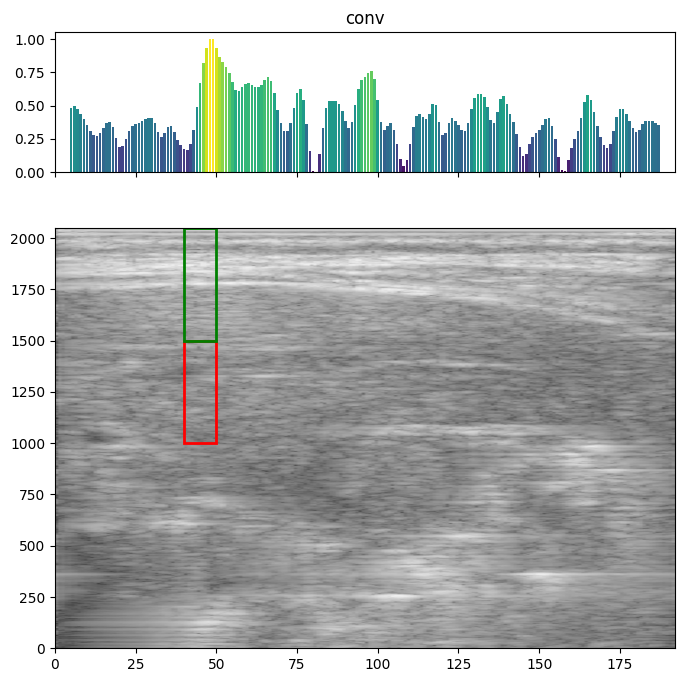

In [41]:
roi = [1000,1500,65,75] # v1,v2,h1,h2
img = amplitude_envelope
ontop_roi = path2roi(img,roi)

x,y,title = apply_kernel(raw_2d,ontop_roi,kernel_type="conv")
plotter(x,y,img,roi,ontop_roi,title=title)


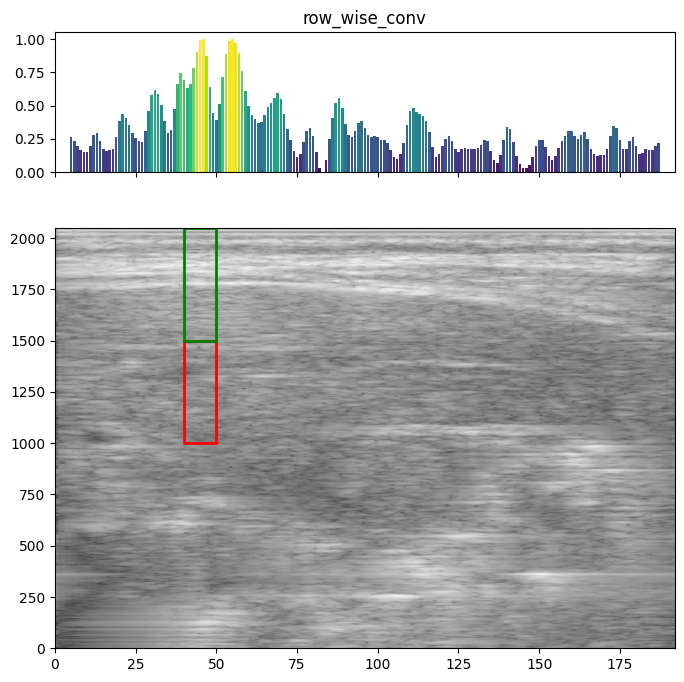

In [42]:
x,y,title = apply_kernel(raw_2d,ontop_roi,kernel_type="row_wise_conv")
plotter(x,y,img,roi,ontop_roi,title=title)

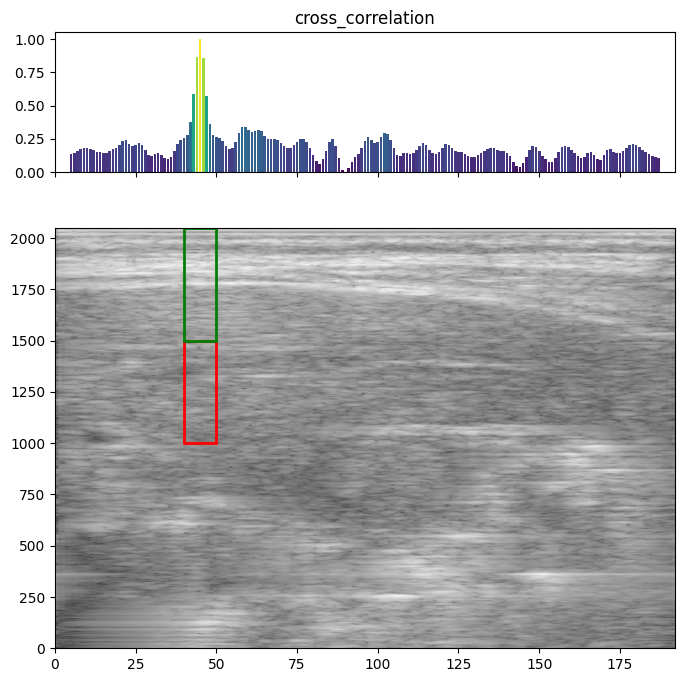

In [43]:
x,y,title = apply_kernel(raw_2d,ontop_roi,kernel_type="cross_correlation")
plotter(x,y,img,roi,ontop_roi,title=title)

# Comparison of different operations

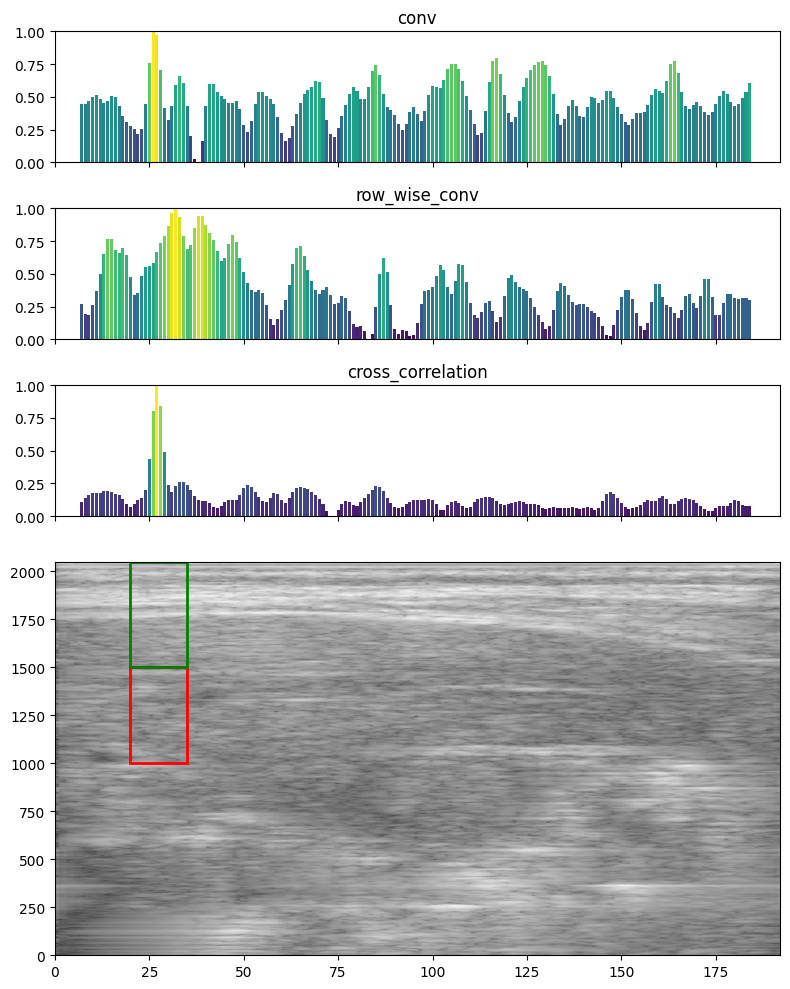

In [44]:
roi = [1000,1500,20,35] # v1,v2,h1,h2
#roi = [1000,1500,65,75] # v1,v2,h1,h2
img = amplitude_envelope
ontop_roi = path2roi(img,roi)
x,y,title = apply_kernel(raw_2d,ontop_roi,getall=True)
plotter(x,y,img,roi,ontop_roi,title=title,plot_all=True)

# Sub Kernels from ROI 
Instead of using the whole ROI as one kernel, we use subsets of it and aggregate the results.
Assuming that smaller sub-regions of interest (sub-ROIs) capture more localized details, while larger full ROIs focus on broader, more global information.
As shown below, subplots can be extracted from the previous tissue of the ROI either horizontal, vertical (with or without an overlap).

<function matplotlib.pyplot.show(close=None, block=None)>

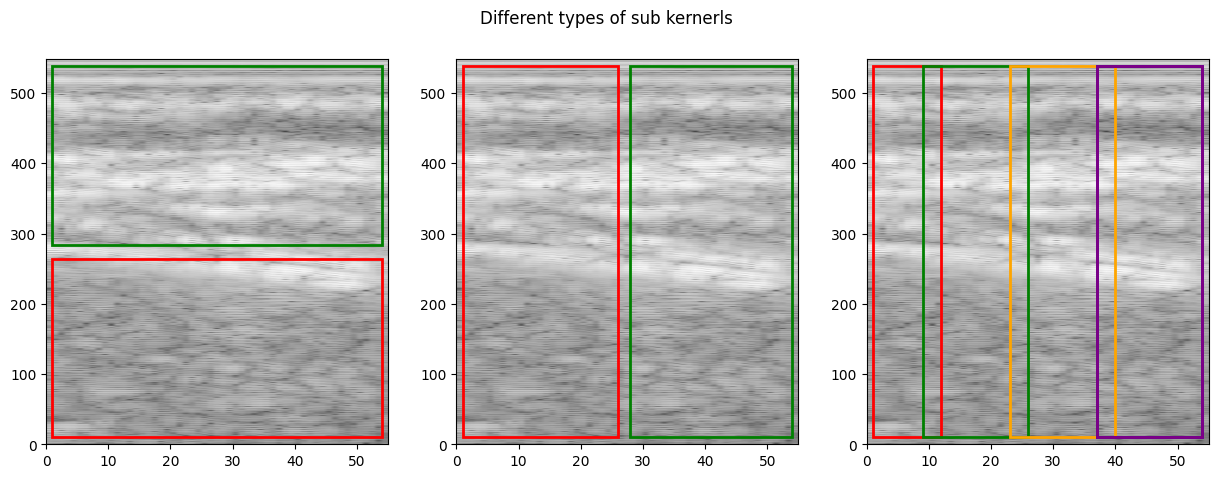

In [49]:
roi = [1000,1500,65,120] # v1,v2,h1,h2
img = amplitude_envelope
ontop_roi = path2roi(img,roi)

img_roi = extract_kernel(img,ontop_roi)
fig, axs = plt.subplots(1,3,figsize=(15,5))
fig.suptitle("Different types of sub kernerls ")
for ax in axs:
     ax.imshow(img_roi, cmap='gray', aspect='auto', extent=[0, img_roi.shape[1], 0, img_roi.shape[0]])


a,b,c,d =  0,np.shape(img_roi)[0],0,np.shape(img_roi)[1]

def reduce_mask(mask):
    eps = 1
    a,b,c,d = mask
    return a+eps*10,b-eps*10,c+eps,d-eps 

first  = [reduce_mask([a,b//2,c,d] ),reduce_mask([b//2,b,c,d])]
second  = [reduce_mask([a,b,c,d//2] ),reduce_mask([a,b,d//2,d])]

ovr = 5
third = [reduce_mask([a,b,c,d//4] ),reduce_mask([a,b,d//4-ovr,2*d//4]),reduce_mask([a,b,2*d//4-ovr,3*d//4]),reduce_mask([a,b,3*d//4-ovr,d]),reduce_mask([a,b,3*d//4-5,d])]
colors2 = ["red","green"]
colors5 = ["red","green","orange","blue","purple"]
for color,rois in zip(colors5,first):
    rect_path = plt_rect(ax,rois,color=color)
    axs[0].add_patch(rect_path)

for color,rois in zip(colors2,second):
    rect_path = plt_rect(ax,rois,color=color)
    axs[1].add_patch(rect_path)

for color,rois in zip(colors5,third):
    rect_path = plt_rect(ax,rois,color=color)
    axs[2].add_patch(rect_path)
plt.show



In [50]:
def get_sub_rois(roi,n,o,vertical=True):
    "function to get the subrois so that they can be used as kernels"
    H = roi[1]-roi[0]
    B = roi[3]-roi[2]

    if vertical:
        b = (B+(n-1)*o)//n
        b_int = int(b)
        sub_rois = [(roi[0],roi[1],a_i := i*(b_int-o)+roi[2],a_i+b_int) for i in range(n)]
    else:
        b = (H+(n-1)*o)//n
        b_int = int(b)
        sub_rois = [(a_i := i*(b_int-o)+roi[0],a_i+b_int,roi[2],roi[3]) for i in range(n)]
    
    assert b-o>1, "overlap too big"
    assert B>n,"n too big "
    
    return sub_rois


# Averaging multiple sub-kernels 
As each sub-kernel corresponds to a barplot, we can aggregate the results.   

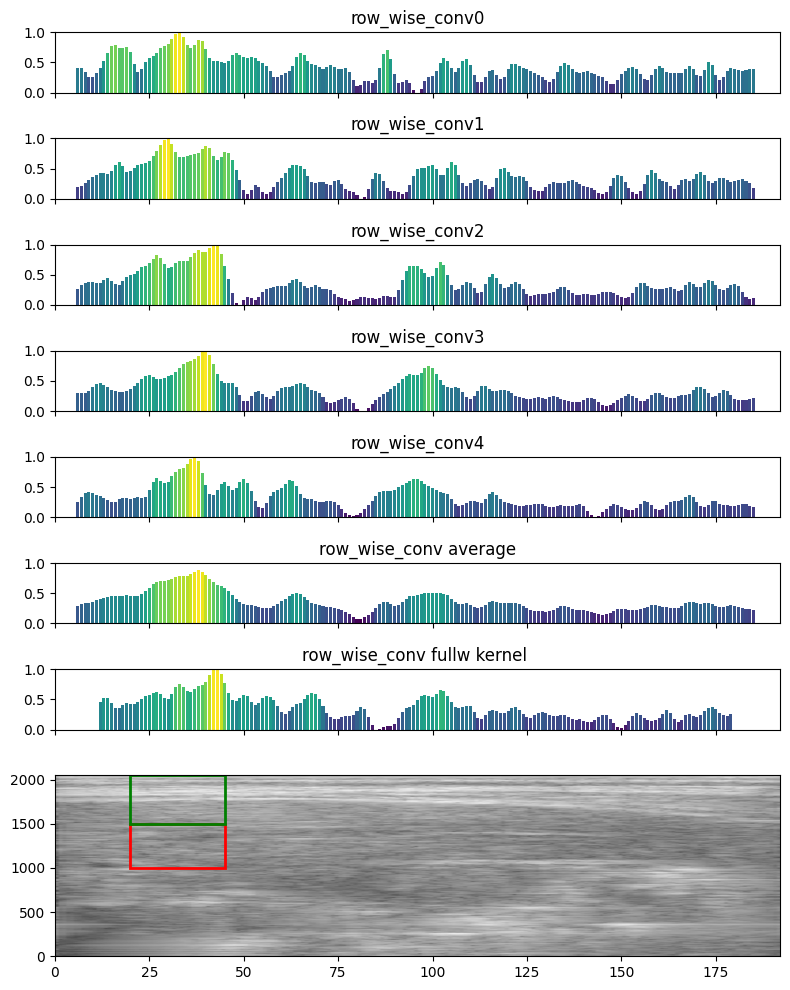

In [53]:
roi = [1000,1500,20,45]
img = amplitude_envelope
ontop_roi = path2roi(img,roi)
vertical = True
subrois = get_sub_rois(ontop_roi,n=5,o=10,vertical=vertical)
kernel_type = "row_wise_conv"#"conv" #"cross_correlation"#"row_wise_conv"

x_list = []
y_list = []
title_list = []
for idx,sub_roi in enumerate(subrois):
    x,y,title = apply_kernel(raw_2d,sub_roi,kernel_type=kernel_type)
    x_list.append(x)
    y_list.append(y)
    title_list.append(title+str(idx))

#Add mean of all sub kernels 
x_list.append(x_list[0])
y_list.append(np.asarray(y_list).mean(axis=0))
title_list.append(kernel_type + " average")

# Add full kernel 
x,y,title = apply_kernel(raw_2d,ontop_roi,kernel_type=kernel_type)
x_list.append(x)
y_list.append(y)
title_list.append(title + " fullw kernel ")

plotter(x_list,y_list,img,roi,ontop_roi,title=title_list,plot_all=True)

# Cross Correlations 
The same can be applied to the cross correlation operation. 

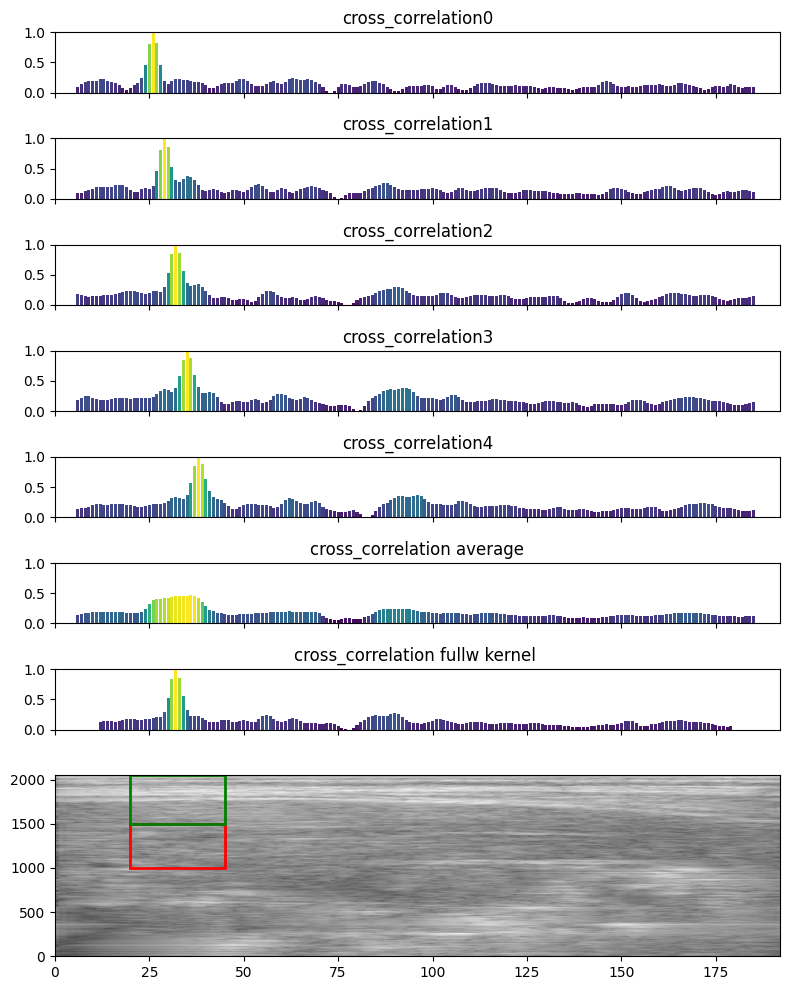

In [57]:
roi = [1000,1500,20,45]
img = amplitude_envelope
ontop_roi = path2roi(raw_2d,roi)
vertical = True
subrois = get_sub_rois(ontop_roi,n=5,o=10,vertical=vertical)
kernel_type = "cross_correlation"#"conv" #"cross_correlation"#"row_wise_conv"

x_list = []
y_list = []
title_list = []
for idx,sub_roi in enumerate(subrois):
    x,y,title = apply_kernel(raw_2d,sub_roi,kernel_type=kernel_type)
    x_list.append(x)
    y_list.append(y)
    title_list.append(title+str(idx))

#Add mean of all sub kernels 
x_list.append(x_list[0])
y_list.append(np.asarray(y_list).mean(axis=0))
title_list.append(kernel_type + " average")

# Add full kernel 
x,y,title = apply_kernel(raw_2d,ontop_roi,kernel_type=kernel_type)
x_list.append(x)
y_list.append(y)
title_list.append(title + " fullw kernel ")

plotter(x_list,y_list,img,roi,ontop_roi,title=title_list,plot_all=True)